# Sarcasm Detection with Bidirectional LSTM

### Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

### Read 'Data.csv'

In [2]:
df = pd.read_csv('Data.csv')

In [28]:
df.head()

,headlines,target
0,CNN Triumphs (At Least in Most Demographic Cat...,Non Sarcastic
1,"‘You Did The Best You Could,’ Says Iron Man Ac...",Sarcastic
2,New Emails Reveal Warm Relationship Between Ka...,Non Sarcastic
3,Donald Trump Jr. Gets Slammed Over Racist Birt...,Non Sarcastic
4,God Urges Rick Perry Not To Run For President,Sarcastic


### Print some of the Headlines along with the target

In [4]:
for i in range(10):
    print(df['headlines'][i],'---',df['target'][i], '\n')

CNN Triumphs (At Least in Most Demographic Categories) --- Non Sarcastic 

‘You Did The Best You Could,’ Says Iron Man Action Figure Voiced By Despondent Toys ‘R’ Us CEO Packing Up Office --- Sarcastic 

New Emails Reveal Warm Relationship Between Kamala Harris And Big Tech --- Non Sarcastic 

Donald Trump Jr. Gets Slammed Over Racist Birtherism Bot Attack On Kamala Harris --- Non Sarcastic 

God Urges Rick Perry Not To Run For President --- Sarcastic 

Global Aid Pours into Haiti --- Non Sarcastic 

CNN Anchor Calls Obama Protester 'Rude' And 'Crazy' --- Non Sarcastic 

Federal Prisons Reinstitute Executions By Lethal Inflation --- Sarcastic 

Lou Dobbs Crumbles When Pressed On His 'NAFTA Super Highway' Myth --- Non Sarcastic 

CNN Still Bent On Debating 'Two Sides' Of The Confederacy --- Non Sarcastic 



### Check Info

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12506 entries, 0 to 12505
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  12506 non-null  object
 1   target     12506 non-null  object
dtypes: object(2)
memory usage: 195.5+ KB


### View basic statistical information about the dataset

In [4]:
df.describe()

,headlines,target
count,12506,12506
unique,12506,2
top,CNN Triumphs (At Least in Most Demographic Cat...,Non Sarcastic
freq,1,6531


### Check for missing values

In [66]:
df.isna().sum()

headlines    0
target       0
dtype: int64

### Check for duplicates

In [67]:
df.duplicated().sum()

0

### Plot a countplot of the Class Index

<Axes: xlabel='count', ylabel='target'>

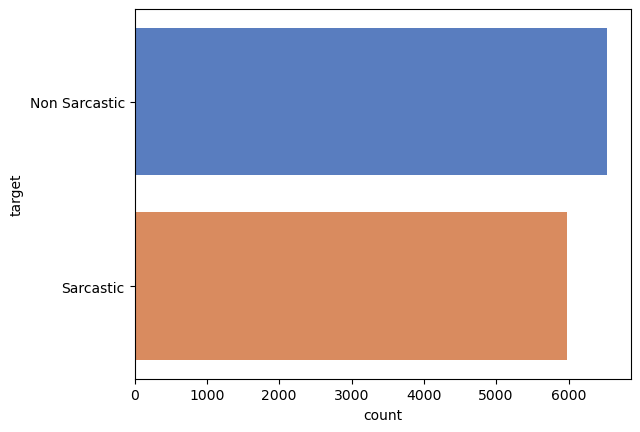

In [68]:
sns.countplot(y= df['target'], palette="muted", hue= df['target'])

### Create a funciton to preprocess the text

In [3]:
def preprocess(data):
    data = data.lower()
    
    text = re.sub(r"[^0-9a-zA-Z]",' ', data).split()
    
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(i) for i in text]
    
    return ' '.join(text)

### Apply the preprocess function to the description

In [4]:
df['headlines'] = df['headlines'].apply(preprocess)

In [7]:
for i in range(10):
    print(df['headlines'][i],'---',df['target'][i], '\n')

cnn triumph at least in most demographic category --- Non Sarcastic 

you did the best you could say iron man action figure voiced by despondent toy r u ceo packing up office --- Sarcastic 

new email reveal warm relationship between kamala harris and big tech --- Non Sarcastic 

donald trump jr get slammed over racist birtherism bot attack on kamala harris --- Non Sarcastic 

god urge rick perry not to run for president --- Sarcastic 

global aid pours into haiti --- Non Sarcastic 

cnn anchor call obama protester rude and crazy --- Non Sarcastic 

federal prison reinstitute execution by lethal inflation --- Sarcastic 

lou dobbs crumbles when pressed on his nafta super highway myth --- Non Sarcastic 

cnn still bent on debating two side of the confederacy --- Non Sarcastic 



### Split Input & Target Variables

In [5]:
X = df['headlines']
y = df['target']

In [6]:
X

0        cnn triumph at least in most demographic category
1        you did the best you could say iron man action...
2        new email reveal warm relationship between kam...
3        donald trump jr get slammed over racist birthe...
4             god urge rick perry not to run for president
                               ...                        
12501                        lapdog of the corporate press
12502    annoying coworker precedes all noun with quite...
12503    report north dakota lead nation in parking ava...
12504    the election night drinking game hypervocal ed...
12505                        conjoined twin hogging kidney
Name: headlines, Length: 12506, dtype: object

In [33]:
y

0        Non Sarcastic
1            Sarcastic
2        Non Sarcastic
3        Non Sarcastic
4            Sarcastic
             ...      
12501    Non Sarcastic
12502        Sarcastic
12503        Sarcastic
12504    Non Sarcastic
12505        Sarcastic
Name: target, Length: 12506, dtype: object

### One Hot encode our Target Variable

In [6]:
from sklearn.preprocessing import LabelBinarizer

In [7]:
encoder = LabelBinarizer()

In [8]:
y = encoder.fit_transform(y)

In [10]:
y

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

### Split the dataset into Training & Testing Set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

### Create a keras Tokenizer object

In the Keras library, the Tokenizer is a class that can be used to preprocess text data. It allows you to convert a collection of text documents into a numerical representation that can be used as input to a machine learning model.

In [12]:
tokenizer = Tokenizer(num_words=5000)

### fit on text for our X

In [13]:
tokenizer.fit_on_texts(X)

In [14]:
vocab_size = len(tokenizer.word_index) + 1

### Create a function to convert text to numerical representation and add padding

In [17]:
def text_encode(txt):
    encoded_docs = tokenizer.texts_to_sequences(txt)
    
    padded_sequence = pad_sequences(encoded_docs, maxlen=128)
    
    return padded_sequence

### Apply the function to our X_train & X_test

In [18]:
X_train = text_encode(X_train)
X_test = text_encode(X_test)

### Create keras Sequential model with GRU Layers

In [20]:
model = Sequential()
model.add(layers.Embedding(vocab_size, 128))

model.add(layers.Bidirectional(layers.GRU(128, return_sequences=True)))
model.add(layers.Dropout(0.2))

model.add(layers.Bidirectional(layers.GRU(128)))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compile the model

In [22]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### Train the model with our Training Set

In [23]:
model.fit(X_train,y_train, epochs= 10, batch_size= 32, validation_split= 0.05)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 53s 150ms/step - accuracy: 0.7155 - loss: 0.5232 - val_accuracy: 0.9062 - val_loss: 0.2661
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - accuracy: 0.9425 - loss: 0.1574 - val_accuracy: 0.9222 - val_loss: 0.2346
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 44s 149ms/step - accuracy: 0.9744 - loss: 0.0832 - val_accuracy: 0.9002 - val_loss: 0.3313
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 45s 150ms/step - accuracy: 0.9855 - loss: 0.0467 - val_accuracy: 0.8982 - val_loss: 0.3377
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 45s 153ms/step - accuracy: 0.9914 - loss: 0.0332 - val_accuracy: 0.9082 - val_loss: 0.3757
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - accuracy: 0.9939 - loss: 0.0246 - val_accuracy: 0.8802 - val_loss: 0.4352
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 46s 155ms/step - accuracy: 0.9958 - loss: 0.0171 - val_accuracy: 0.8962 - val_loss: 0.4218
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 47s 157ms/step - accuracy: 0.9953 - loss: 0

### Make predictions with Test set

In [25]:
y_pred = model.predict(X_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


In [30]:
y_pred = [np.argmax(i) for i in y_pred]

### Check accuracy score

In [162]:
accuracy_score(y_pred, y_test)

0.8840927258193445

### Confusion matrix

<Axes: >

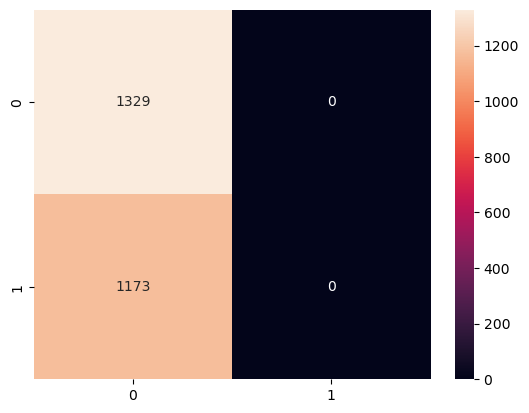

In [32]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')

### Classification Report

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      1.00      0.69      1329
           1       0.00      0.00      0.00      1173

    accuracy                           0.53      2502
   macro avg       0.27      0.50      0.35      2502
weighted avg       0.28      0.53      0.37      2502



C:\Users\mnkv1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mnkv1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mnkv1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***